# Setting Up

In [1]:
#%% Setting Up
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import networkx as nx
import rioxarray as rxr

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely.geometry import Polygon

import glob
import os
import itertools
import tqdm
import gc
import time
import pickle

from joblib import Parallel, delayed

import rioxarray as rxr

import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/home/sarth/rootdir/datadir/assets/defaults.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

print("Setting up...")

Setting up...


In [2]:
#%% Region-Specific: CAMELS-US
DIRNAME = '03min_GloFAS_CAMELS-US'
SAVE_PATH = os.path.join(PATHS['devp_datasets'], DIRNAME)
resolution = 0.05
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': -130,
    'miny': 20,
    'maxx': -65,
    'maxy': 50
}
camels_attributes_graph = pd.read_csv(os.path.join(SAVE_PATH, 'graph_attributes.csv'), index_col=0)
camels_attributes_graph.index = camels_attributes_graph.index.map(lambda x: str(x).zfill(8))
camels_attributes_graph['huc_02'] = camels_attributes_graph['huc_02'].map(lambda x: str(x).zfill(2))
camels_graph = camels_attributes_graph.copy()
camels_graph = camels_graph[camels_graph['area_percent_difference'] < 10]
camels_graph = camels_graph[camels_graph['num_nodes'] > 1]
print(f"Number of CAMELS-US catmt's: {len(camels_graph)}")
del camels_attributes_graph

Number of CAMELS-US catmt's: 395


In [3]:
region_shp = gpd.read_file(os.path.join(PATHS['watershed-boundary-dataset'], 'huc02', 'shapefile.shp'), crs = 'epsg:4326')
all_watersheds = region_shp.copy()
all_watersheds = all_watersheds.rename(columns={'huc2': 'watershed'})
all_watersheds['huc_02'] = all_watersheds['watershed'].map(lambda x: x.split('_')[0])

In [4]:
temp = gpd.read_file(os.path.join(PATHS['CAMELS'], 'CAMELS-US', 'HCDN_nhru_final_671.shp'), crs = 'epsg:4326')
temp = temp[['hru_id', 'geometry']]
temp['hru_id'] = temp['hru_id'].map(lambda x: str(x).zfill(8))
temp = temp.set_index('hru_id')

all_catchments = camels_graph.merge(temp, left_index=True, right_index=True, how='left')
all_catchments = all_catchments[['huc_02', 'gauge_lon', 'gauge_lat', 'area_geospa_fabric', 'geometry', 'snapped_lon', 'snapped_lat']]
all_catchments = gpd.GeoDataFrame(all_catchments, crs='epsg:4326', geometry='geometry')
all_catchments = all_catchments.reset_index()
del temp

# Plot catchments

In [ ]:
def plot_catchments():
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

    all_watersheds.plot(
        ax = ax,
        column='watershed',
        cmap='tab20',
        edgecolor='gray',
        linewidth=0.5,
        legend=True,
        legend_kwds={'loc': 'lower right', 'bbox_to_anchor': (1.1, 0.0), 'fontsize': 5, 'markerscale': 0.5, 'frameon': True, 'facecolor': 'white', 'ncol': 1}
    )

    scatter = ax.scatter(
        camels_graph['gauge_lon'],
        camels_graph['gauge_lat'],
        # c=camels_graph['num_nodes'],  # Color by num_nodes
        # c=np.log10(camels_graph['num_nodes']),  # Color by num_nodes
        c='k',
        s=5,  # Fixed marker size
        edgecolor='black',
        linewidth=0.25,
        marker = '^'
    )

    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    # plt.xlabel('Longitude')
    # plt.ylabel('Latitude')
    plt.axis('off')
    # plt.savefig(os.path.join(f'CAMELS-US.png'), dpi=600)
    # plt.close()
    plt.show()

plot_catchments()

# Create Nesting Info

In [6]:
import pickle
import json
import matplotlib.cm as cm

In [9]:
def get_watershed_info(
        huc, 
        watershed, 
        path_plot, 
        path_json,
        show_plot=True
    ):
    if path_plot is not None: os.makedirs(os.path.dirname(path_plot), exist_ok=True)
    if path_json is not None: os.makedirs(os.path.dirname(path_json), exist_ok=True)

    gauges = camels_graph[camels_graph['huc_02'] == huc]

    nested_gauges = {}
    all_nodes = []
    # all_edges = []
    for idx, row in gauges.iterrows():
        gauge_id, huc = row.name, row['huc_02']

        nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        nodes_coords['gauge_id'] = gauge_id
        all_nodes.append(nodes_coords)

        # edges = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'edges.csv'), index_col = 0)
        # for col1, col2 in zip(['start', 'end'], ['from', 'to']):
            # edges[f'{col1}_lon'] = edges.apply(lambda x: eval(x[col2])[0], axis=1)
            # edges[f'{col1}_lat'] = edges.apply(lambda x: eval(x[col2])[1], axis=1)
        # edges = edges[['start_lon', 'start_lat', 'end_lon', 'end_lat']]
        # all_edges.append(edges)

        nested_gauges[gauge_id] = []
        gauges_temp = gauges.reset_index()[['gauge_id', 'snapped_lon', 'snapped_lat', 'huc_02']]
        gauges_temp.rename(columns={'gauge_id': 'gauge_name'}, inplace=True)
        merged = pd.merge(nodes_coords, gauges_temp,
                        left_on=['lon', 'lat'],
                        right_on=['snapped_lon', 'snapped_lat'],
                        how='left')

        merged = merged[merged['gauge_name'].notnull()]
        merged = merged[merged.index != 0]
        for match_idx, match_row in merged.iterrows():
            temp = [match_row['huc_02'], match_row['gauge_name'], match_idx]
            nested_gauges[gauge_id].append(temp)

    all_nodes = pd.concat(all_nodes)
    all_nodes.drop_duplicates(subset=['lat', 'lon'], inplace=True, keep='first', ignore_index=True)
    # all_edges = pd.concat(all_edges)
    # all_edges.drop_duplicates(subset=['start_lon', 'start_lat', 'end_lon', 'end_lat'], inplace=True, keep='first', ignore_index=True)

    # Sort the dict nested_gauges by gauge_id
    nested_gauges = dict(sorted(nested_gauges.items(), key=lambda item: item[0]))
    # Save as a json instead of pickle
    if path_json is not None:
        with open(os.path.join(path_json), 'w') as f:
            json.dump(nested_gauges, f, indent=4)

    # all_catchments_huc: Filter by gauge_id which is index of gauges.
    all_catchments_huc = all_catchments[all_catchments['gauge_id'].isin(gauges.index)]

    if (path_plot is not None) or show_plot:
        fig, ax = plt.subplots(figsize=(10, 10), dpi=600)
        all_watersheds[all_watersheds['watershed'] == watershed].plot(
            ax = ax,
            facecolor='none',
            edgecolor='gray',
            linewidth=0.5,
        )
        all_catchments_huc.plot(
            ax = ax,
            facecolor='none',
            edgecolor='gray',
            linewidth=0.5,
        )
        # Create a unique color for each gauge_id
        unique_ids = gauges.index.unique()
        cmap = cm.get_cmap("tab20", len(unique_ids))
        color_assignments = {gauge_id: cmap(i) for i, gauge_id in enumerate(unique_ids)}
        ax.scatter(
            all_nodes['lon'],
            all_nodes['lat'],
            c= [color_assignments[g] for g in all_nodes['gauge_id']],
            s=1,  # Fixed marker size
            marker = 'o'
        )
        scatter = ax.scatter(
            gauges['gauge_lon'],
            gauges['gauge_lat'],
            c=[color_assignments[g] for g in gauges.index],
            s=25,  # Fixed marker size
            marker='^',
            edgecolor='black',
            linewidth=0.25
        )
        # Create legend using the unique color for each gauge_id
        # for gauge_id in unique_ids:
        #     ax.scatter([], [], color=color_assignments[gauge_id],
        #             label=gauges.loc[gauge_id, 'cwc_site_name'], marker='^', s=25, edgecolor='black', linewidth=0.25)
        # ax.legend(loc='upper center', fontsize=8, markerscale=1, ncol = 4, bbox_to_anchor=(0.5, 0.0))
        # ax.legend(loc='upper right', fontsize=4, markerscale=1, ncol = 1, bbox_to_anchor=(1.0, 1.0))
        # plt.xticks(fontsize=6)
        # plt.yticks(fontsize=6)
        plt.axis('off')
        if path_plot is not None:
            plt.savefig(path_plot)

        if show_plot:
            plt.show()
        else:
            plt.close()

    return nested_gauges

In [ ]:
watershed = '05'
huc = watershed.split('_')[0]
temp = get_watershed_info(
    huc, watershed, 
    path_plot = None, #os.path.join(SAVE_PATH, 'huc_plots', f'{huc}.png'),
    path_json = os.path.join(SAVE_PATH, 'nested_gauges', 'upstream_gauges', f'HUC{huc}.json'),
    show_plot=False
    )
temp

{'03010655': [],
 '03015500': [],
 '03021350': [],
 '03049000': [],
 '03050000': [],
 '03069500': [],
 '03070500': [],
 '03078000': [],
 '03140000': [],
 '03144000': [],
 '03161000': [],
 '03164000': [['05', '03161000', 89]],
 '03170000': [],
 '03173000': [],
 '03182500': [],
 '03186500': [],
 '03187500': [],
 '03213700': [],
 '03237500': [],
 '03280700': [],
 '03281500': [],
 '03285000': [],
 '03300400': [],
 '03338780': [],
 '03340800': [],
 '03384450': []}

In [ ]:
for i in range(1,18+1):
    watershed = f'{str(i).zfill(2)}'
    huc = watershed.split('_')[0]
    try:
        _ = get_watershed_info(
            huc, watershed, 
            path_plot = None, #os.path.join(SAVE_PATH, 'huc_plots', f'{huc}.png'),
            path_json = os.path.join(SAVE_PATH, 'nested_gauges', 'upstream_gauges', f'HUC{huc}.json'),
            show_plot=False
            )
        print(f'Completed {watershed}')
    except:
        print(f'Failed {watershed}')

Completed 01
Completed 02
Completed 03
Completed 04
Completed 05
Completed 06
Completed 07
Completed 08
Completed 09
Completed 10
Completed 11
Completed 12
Completed 13
Completed 14
Completed 15
Completed 16
Completed 17
Completed 18


# Hierarchy of Nested Gauges

In [16]:
def build_gauge_tree(G: nx.DiGraph, gauges: list) -> dict:
    """
    Build a gauge tree that represents the upstream-downstream hierarchy of a subset of nodes (gauges)
    in a river network.

    Parameters:
        G (nx.DiGraph): A directed acyclic graph representing the river network.
        gauges (list): A list of nodes in G that represent gauge stations.

    Returns:
        dict: A dictionary mapping each gauge to a list of its immediate downstream gauge stations.
              An "immediate" downstream gauge is the first gauge encountered along any downstream path,
              meaning that if there is an intermediate (non-gauge) node between gauges, it is skipped.
    """
    gauge_set = set(gauges)
    tree = {g: [] for g in gauges}

    # For each gauge, do a DFS to find the first gauge in each downstream branch.
    for gauge in gauges:
        stack = list(G.successors(gauge))
        visited = set()
        while stack:
            current = stack.pop()
            if current in visited:
                continue
            visited.add(current)
            if current in gauge_set:
                # Found a gauge: add it as an immediate downstream gauge for 'gauge'
                if current not in tree[gauge]:
                    tree[gauge].append(current)
                # Do not continue exploring from here on this branch.
            else:
                # Continue exploring downstream.
                stack.extend(G.successors(current))
    return tree

def build_nested_gauge_tree(gauge_tree: dict) -> list:
    """
    Convert a gauge tree dictionary into a nested dictionary structure for easier visualization.

    Parameters:
        gauge_tree (dict): A dictionary mapping each gauge to its immediate downstream gauge(s).

    Returns:
        list: A list of nested dictionaries representing the gauge hierarchy.
              Each dictionary has one key (the gauge) with a value that is a list of its downstream subtree(s).
    """
    # Identify root gauges: those that never appear as a downstream child.
    all_children = {child for children in gauge_tree.values() for child in children}
    roots = [g for g in gauge_tree if g not in all_children]

    def build_subtree(gauge):
        return {gauge: [build_subtree(child) for child in gauge_tree[gauge]]}

    return [build_subtree(root) for root in roots]

def build_gauge_graph(nested_tree: list) -> nx.DiGraph:
    """
    Build a directed graph (G_gauges) representing the gauge hierarchy from the nested tree structure.
    
    Parameters:
        nested_tree (list): A list of nested dictionaries representing the gauge hierarchy.
                            Each dictionary has a single key (the gauge) with a list of its children (subtrees).
    
    Returns:
        nx.DiGraph: A directed graph where nodes are gauges and edges represent parent-child relationships.
    """
    G_gauges = nx.DiGraph()
    
    def process_tree(tree, parent=None):
        # Each tree is a dictionary with one key (the gauge) and a list of children.
        for gauge, children in tree.items():
            G_gauges.add_node(gauge)
            if parent is not None:
                G_gauges.add_edge(parent, gauge)
            # Each child in 'children' is itself a nested dictionary (or subtree)
            for child_tree in children:
                process_tree(child_tree, gauge)
    
    # Process each tree in the list of nested trees.
    for tree in nested_tree:
        process_tree(tree)
    
    return G_gauges

def get_gauge_nested_info(
    huc, 
    downstream_gauge,
    nested_gauges,
    path,
    verbose = False,
    legend_loc = None
    ):
    if verbose: print(f"Downstream Gauge: {downstream_gauge}")
    upstream_gauges = [x[1] for x in nested_gauges[downstream_gauge]]
    if verbose: print(f"Upstream Gauges: {upstream_gauges}")
    upstream_gauges_idxs = [x[2] for x in nested_gauges[downstream_gauge]]

    downstream_catchment = all_catchments[all_catchments['gauge_id'] == downstream_gauge]
    upstream_catchments = all_catchments[all_catchments['gauge_id'].isin(upstream_gauges)]

    nested_gauges_detailed = {
        'downstream_gauge': downstream_gauge,
        'num_nodes': None,
        'num_nodes_lateral_inflow': None,
        'upstream_gauges': {
            x: {
                # 'upstream': None,
                # 'next_downstream': None,
                'num_nodes': None,
                'num_nodes_lateral_inflow': None,
                'node_idx' : x_idx,
            } for x, x_idx in zip(upstream_gauges, upstream_gauges_idxs)
        }
    }

    downstream_nodes = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, downstream_gauge, 'nodes_coords.csv'), index_col = 0)
    downstream_edges = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, downstream_gauge, 'edges.csv'), index_col = 0)
    if verbose: print(f"Num of Total Nodes: {downstream_nodes.shape[0]} ({downstream_nodes.columns.tolist()})")
    if verbose: print(f"Num of Total Edges: {downstream_edges.shape[0]} ({downstream_edges.columns.tolist()})")

    nested_gauges_detailed['num_nodes'] = downstream_nodes.shape[0]

    downstream_nodes['assigned_gauge_id'] = None

    G = nx.DiGraph()
    G.add_nodes_from(downstream_nodes.index)
    for edge in downstream_edges[['from_idx', 'to_idx']].values:
        G.add_edge(int(edge[0]), int(edge[1]))

    nodes_list = [0] + upstream_gauges_idxs
    if verbose: print(nodes_list)
    gauge_tree = build_gauge_tree(G, nodes_list)
    if verbose: print("Gauge tree (flat dictionary):")
    if verbose: print(gauge_tree)

    nested_tree = build_nested_gauge_tree(gauge_tree)
    if verbose: print("\nNested gauge tree:")
    if verbose: print(nested_tree)

    G_gauges = build_gauge_graph(nested_tree)

    pos = {node: (downstream_nodes.loc[node]['lon'], downstream_nodes.loc[node]['lat']) for node in G_gauges.nodes}

    # Sort the nodes in G_gauges by their depth in the tree
    depths = nx.single_source_shortest_path_length(G_gauges.reverse(), 0)
    sorted_nodes = sorted(G_gauges.nodes, key=lambda x: depths[x], reverse=True)
    if verbose: print("Sorted nodes (index):", sorted_nodes)
    map_idx_names = {idx: name for idx, name in zip(upstream_gauges_idxs, upstream_gauges)}
    # Seperately add the downstream gauge to map_idx_names
    map_idx_names[0] = downstream_gauge
    sorted_nodes_names = [map_idx_names[x] for x in sorted_nodes]
    if verbose: print("Sorted nodes (gauge_id):", sorted_nodes_names)

    for gauge_id, gauge_idx in zip(sorted_nodes_names, sorted_nodes):
        ancestors = list(nx.ancestors(G, gauge_idx))
        downstream_nodes.loc[gauge_idx, 'assigned_gauge_id'] = gauge_id
        for node in ancestors:
            if downstream_nodes.loc[node, 'assigned_gauge_id'] is None:
                downstream_nodes.loc[node, 'assigned_gauge_id'] = gauge_id

        if gauge_id != downstream_gauge:
            nested_gauges_detailed['upstream_gauges'][gauge_id]['num_nodes'] = len(ancestors) + 1
            nested_gauges_detailed['upstream_gauges'][gauge_id]['num_nodes_lateral_inflow'] = len(downstream_nodes[downstream_nodes['assigned_gauge_id'] == gauge_id])
        else:
            nested_gauges_detailed['num_nodes_lateral_inflow'] = len(downstream_nodes[downstream_nodes['assigned_gauge_id'] == gauge_id])

    os.makedirs(path, exist_ok = True)
    # Things that will be saved: downstream_nodes, edges_gauges (Edges from G_gauges), nested_gauges.json (nested_gauges_detailed)
    # SAVE_PATH: PATHS['Assets']/nested_gauges/DIRNAME/huc/downstream_gauge
    # FILES: nodes_coords_assigned.csv, edges_gauges.csv, nested_gauges.json,
    downstream_nodes.to_csv(os.path.join(path, 'nodes_coords_assigned.csv'))
    edges_gauges = pd.DataFrame(G_gauges.edges, columns = ['from_idx', 'to_idx'])
    # from: (lon, lat) as str
    edges_gauges['from'] = edges_gauges['from_idx'].map(lambda x: f"({downstream_nodes.loc[x]['lon']}, {downstream_nodes.loc[x]['lat']})")
    # to: (lon, lat)
    edges_gauges['to'] = edges_gauges['to_idx'].map(lambda x: f"({downstream_nodes.loc[x]['lon']}, {downstream_nodes.loc[x]['lat']})")
    edges_gauges.to_csv(os.path.join(path, 'edges_gauges.csv'))
    with open(os.path.join(path, 'nested_gauges.json'), 'w') as f:
        json.dump(nested_gauges_detailed, f, indent=4)

    cmap = cm.get_cmap("tab20", 20)
    buffer = 0.01

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi = 300)

    # Plot the catchments
    downstream_catchment.plot(ax=ax, color=cmap(0), edgecolor='gray', linewidth=1, alpha = 0.75)
    for idx, upstream_gauge in enumerate(upstream_gauges):
        upstream_catchments[upstream_catchments['gauge_id'] == upstream_gauge].plot(ax=ax, color=cmap(idx+1), edgecolor='gray', linewidth=1, alpha = 0.75)

    # Scatter plot for nodes which are assigned to downstream gauge
    ax.scatter(
        downstream_nodes[downstream_nodes['assigned_gauge_id'] == downstream_gauge]['lon'],
        downstream_nodes[downstream_nodes['assigned_gauge_id'] == downstream_gauge]['lat'],
        color=cmap(0), s=25, edgecolor='black', linewidth=1
    )
    for idx, upstream_gauge in enumerate(upstream_gauges):
        # Scatter plot for nodes which are assigned to upstream gauge
        ax.scatter(
            downstream_nodes[downstream_nodes['assigned_gauge_id'] == upstream_gauge]['lon'],
            downstream_nodes[downstream_nodes['assigned_gauge_id'] == upstream_gauge]['lat'],
            color=cmap(idx+1), s=25, edgecolor='black', linewidth=1
        )

    edge_list = downstream_edges.loc[:,['from_idx', 'to_idx']].values.tolist()
    for edge in edge_list:
        from_idx, to_idx = edge
        from_x, from_y = downstream_nodes.loc[from_idx, ['lon', 'lat']]
        to_x, to_y = downstream_nodes.loc[to_idx, ['lon', 'lat']]
        ax.annotate("", xy=(to_x, to_y), xytext=(from_x, from_y), arrowprops=dict(arrowstyle="-|>", mutation_scale=7, color = 'k', lw = 0.5))

    # Plot the gauge hierarchy
    nx.draw(
        G_gauges, pos=pos, ax=ax, 
        node_color='black', node_size=1, 
        edge_color='cyan', style='dashed',
        width=2.5, arrowsize=15, arrowstyle='-|>',
        with_labels=False, arrows=True)

    # Gauge Locations
    ax.scatter(camels_graph.loc[downstream_gauge]['gauge_lon'], camels_graph.loc[downstream_gauge]['gauge_lat'], color='k', s=100, edgecolor='black', linewidth=1, marker = '^')
    for idx, upstream_gauge in enumerate(upstream_gauges):
        ax.scatter(camels_graph.loc[upstream_gauge]['gauge_lon'], camels_graph.loc[upstream_gauge]['gauge_lat'], color='k', s=100, edgecolor='black', linewidth=1, marker = '^')

    # Custom legend handles with labels of form '{gauge_id}: {cwc_site_name}' and color using cmap
    legend_handles1 = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(0), markersize=10, label=f"{downstream_gauge}"),
        *[
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(idx+1), markersize=10, label=f"{upstream_gauge}")
            for idx, upstream_gauge in enumerate(upstream_gauges)
        ]
    ]
    legend_handles2 = [
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='k', markersize=10, label='Gauge Locations'),
        plt.Line2D([0], [0], color='cyan', lw=2.5, linestyle='dashed', label='Gauge Hierarchy')
    ]

    legend_handles1 = legend_handles1 + legend_handles2

    if legend_loc is not None:
        try:
            legend1 = ax.legend(handles=legend_handles1, loc=legend_loc[0], fontsize=10, bbox_to_anchor=legend_loc[1])
        except:
            legend1 = ax.legend(handles=legend_handles1, loc='best', fontsize=10)
    else:
        legend1 = ax.legend(handles=legend_handles1, loc='best', fontsize=10)

    # plt.show()
    plt.savefig(os.path.join(path, 'nested_gauges.png'), bbox_inches='tight')
    plt.close()

    return None

In [17]:
for huc in [str(x).zfill(2) for x in range(1, 18+1)]:
    try:
        with open(os.path.join(SAVE_PATH, 'nested_gauges', 'upstream_gauges', f'HUC{huc}.json'), 'r') as f:
            nested_gauges = json.load(f)
        nested_gauges = {k: v for k, v in nested_gauges.items() if len(v) > 0}

        gauge_lists = {downstream_gauge: set([downstream_gauge] + [x[1] for x in nested_gauges[downstream_gauge]]) for downstream_gauge in nested_gauges.keys()}

        if len(nested_gauges.keys()) > 0:
            # Filter out downstream gauges whose gauge_lists aren't subset of any of the other gauge_lists
            downstream_gauges = list(gauge_lists.keys())
            valid_downstream_gauges = []
            invalid_downstream_gauges = []
            for key1 in downstream_gauges:
                is_subset = False
                for key2 in downstream_gauges:
                    if key1 == key2:
                        continue
                    if gauge_lists[key1].issubset(gauge_lists[key2]):
                        is_subset = True
                        break
                if not is_subset:
                    valid_downstream_gauges.append(key1)
                else:
                    invalid_downstream_gauges.append(key1)

            print(f"Number of nested gauges in HUC {huc}: {len(valid_downstream_gauges)}")
            # print(f"Number of nested gauges in {huc}: {len(nested_gauges.keys())} {list(nested_gauges.keys())}")
            # for k, v in nested_gauges.items():
            #     print(k, len(v))
            for downstream_gauge in tqdm.tqdm(valid_downstream_gauges):
                # path = os.path.join(PATHS['Assets'], 'preparation', 'nested_gauges', DIRNAME, huc, downstream_gauge)
                path = os.path.join(SAVE_PATH, 'nested_gauges', 'nesting_info', huc, downstream_gauge)
                get_gauge_nested_info(huc, downstream_gauge, nested_gauges, path, verbose = False, legend_loc = None)
        else:
            print(f"Number of nested gauges in HUC {huc}: 0")
    except:
        print(f"Number of nested gauges in HUC {huc}: 0 (No json file found)")

Number of nested gauges in HUC 01: 0
Number of nested gauges in HUC 02: 3


100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


Number of nested gauges in HUC 03: 1


100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


Number of nested gauges in HUC 04: 0
Number of nested gauges in HUC 05: 1


100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


Number of nested gauges in HUC 06: 0
Number of nested gauges in HUC 07: 1


100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


Number of nested gauges in HUC 08: 0
Number of nested gauges in HUC 09: 0
Number of nested gauges in HUC 10: 8


100%|██████████| 8/8 [00:58<00:00,  7.25s/it]


Number of nested gauges in HUC 11: 3


100%|██████████| 3/3 [00:13<00:00,  4.39s/it]


Number of nested gauges in HUC 12: 1


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Number of nested gauges in HUC 13: 1


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Number of nested gauges in HUC 14: 0
Number of nested gauges in HUC 15: 0
Number of nested gauges in HUC 16: 0
Number of nested gauges in HUC 17: 2


100%|██████████| 2/2 [00:16<00:00,  8.12s/it]

Number of nested gauges in HUC 18: 0


# Modify Graph Attributes with Nesting Info

In [18]:
camels_graph_with_nesting = camels_graph.copy()
camels_graph_with_nesting['nesting'] = 'not_nested'

for idx, row in tqdm.tqdm(camels_graph_with_nesting.iterrows()):
    huc = row['huc_02']
    downstream_gauge = row.name
    path = os.path.join(SAVE_PATH, 'nested_gauges', 'nesting_info', huc, downstream_gauge)

    if os.path.exists(path):
        camels_graph_with_nesting.loc[idx, 'nesting'] = 'nested_downstream'
        # load nested_gauges.json
        with open(os.path.join(path, 'nested_gauges.json'), 'r') as f:
            nested_gauges = json.load(f)
        upstream_gauges = list(nested_gauges['upstream_gauges'].keys())
        for upstream_gauge in upstream_gauges:
            camels_graph_with_nesting.loc[upstream_gauge, 'nesting'] = 'nested_upstream'

# value_counts
camels_graph_with_nesting['nesting'].value_counts()

395it [00:00, 5820.61it/s]


nesting
not_nested           348
nested_upstream       26
nested_downstream     21
Name: count, dtype: int64

In [19]:
camels_graph_with_nesting.to_csv(os.path.join(SAVE_PATH, 'nested_gauges', 'graph_attributes_with_nesting.csv'), index = True)

# Make Batched Graphs

In [9]:
import pickle
import json
import matplotlib.cm as cm

In [5]:
camels_graph = pd.read_csv(os.path.join(SAVE_PATH, 'nested_gauges', 'graph_attributes_with_nesting.csv'), index_col=0)
camels_graph.index = camels_graph.index.map(lambda x: str(x).zfill(8))
camels_graph['huc_02'] = camels_graph['huc_02'].map(lambda x: str(x).zfill(2))
# camels_graph = camels_graph[camels_graph['area_percent_difference'] < 10]
# camels_graph = camels_graph[camels_graph['num_nodes'] > 1]
print(f"Number of catmt's: {len(camels_graph)}")

camels_graph = camels_graph[camels_graph['nesting'].isin(['not_nested', 'nested_downstream'])]
camels_graph = camels_graph.reset_index()
print(f"Number of catmt's with nesting: {len(camels_graph)}")

Number of catmt's: 395
Number of catmt's with nesting: 369


In [6]:
print(f"Total Number of Nodes: {int(camels_graph['num_nodes'].sum())}")

Total Number of Nodes: 17400


In [7]:
def create_batches(df, MAX_NODES_PER_BATCH = 1024, id_column = 'gauge_id', num_nodes_column = 'num_nodes', verbose = True):
    # ---------------------------
    # Step 3: Sort the graphs in descending order by number of nodes.
    # ---------------------------
    # Sorting in descending order helps the greedy algorithm perform better.
    df_sorted = df.sort_values(by='num_nodes', ascending=False).reset_index(drop=True)

    # ---------------------------
    # Step 4: Initialize batch containers.
    # ---------------------------
    # We will store batches as a list of dictionaries,
    # where each dictionary has 'graph_ids' and 'sum_num_nodes' keys.
    batches_list = []

    # ---------------------------
    # Step 5: Greedy bin-packing using Best Fit Decreasing heuristic.
    # ---------------------------
    for idx, row in df_sorted.iterrows():
        graph_id = row[id_column]
        num_nodes = row[num_nodes_column]
        
        # Sanity check: if a single graph exceeds MAX_NODES_PER_BATCH, raise an error.
        if num_nodes > MAX_NODES_PER_BATCH:
            raise ValueError(f"Graph {graph_id} with {num_nodes} nodes exceeds the maximum allowed per batch.")
        
        best_fit_idx = None
        min_remaining_capacity = MAX_NODES_PER_BATCH + 1  # start with a value greater than max capacity
        
        # Iterate over existing batches to find the best batch to fit this graph.
        for i, batch in enumerate(batches_list):
            # Check if the graph can fit in the current batch.
            if batch['sum_num_nodes'] + num_nodes <= MAX_NODES_PER_BATCH:
                remaining_capacity = MAX_NODES_PER_BATCH - (batch['sum_num_nodes'] + num_nodes)
                # Choose the batch that leaves the least remaining capacity (i.e., as full as possible)
                if remaining_capacity < min_remaining_capacity:
                    best_fit_idx = i
                    min_remaining_capacity = remaining_capacity
                    
        # If a suitable batch is found, add the graph to it.
        if best_fit_idx is not None:
            batches_list[best_fit_idx]['graph_ids'].append(graph_id)
            batches_list[best_fit_idx]['sum_num_nodes'] += num_nodes
        else:
            # Otherwise, create a new batch with this graph.
            new_batch = {'graph_ids': [graph_id], 'sum_num_nodes': num_nodes}
            batches_list.append(new_batch)

    # ---------------------------
    # Step 6: Convert list of batches into the desired dictionary format.
    # ---------------------------
    batches = {i: batch for i, batch in enumerate(batches_list)}

    # ---------------------------
    # Step 7: Print out batch statistics.
    # ---------------------------
    if verbose: 
        print("\nBatch assignments:")
        for batch_idx, batch in batches.items():
            print(f"Batch {batch_idx}: {len(batch['graph_ids'])} graphs, Total nodes = {batch['sum_num_nodes']}")

    # Optionally, show how many batches were created.
    print(f"\nTotal number of batches created: {len(batches)}")

    # histogram of the number of graphs per batch

    # Count the number of graphs in each batch.
    graph_counts = [len(batch['graph_ids']) for batch in batches.values()]

    if verbose: 
        # Plot a bar plot of the number of graphs per batch.
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(graph_counts)), graph_counts, color='skyblue', edgecolor='black')
        plt.ylabel("Number of graphs in batch")
        plt.xlabel("Batch Number")
        plt.title("Number of Graphs per Batch")
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    return batches

(369, 4)

Batch assignments:
Batch 0: 2 graphs, Total nodes = 1160.0
Batch 1: 3 graphs, Total nodes = 1160.0
Batch 2: 4 graphs, Total nodes = 1160.0
Batch 3: 5 graphs, Total nodes = 1160.0
Batch 4: 6 graphs, Total nodes = 1160.0
Batch 5: 8 graphs, Total nodes = 1160.0
Batch 6: 10 graphs, Total nodes = 1160.0
Batch 7: 13 graphs, Total nodes = 1160.0
Batch 8: 16 graphs, Total nodes = 1160.0
Batch 9: 20 graphs, Total nodes = 1160.0
Batch 10: 25 graphs, Total nodes = 1160.0
Batch 11: 31 graphs, Total nodes = 1160.0
Batch 12: 38 graphs, Total nodes = 1160.0
Batch 13: 58 graphs, Total nodes = 1160.0
Batch 14: 130 graphs, Total nodes = 1160.0

Total number of batches created: 15


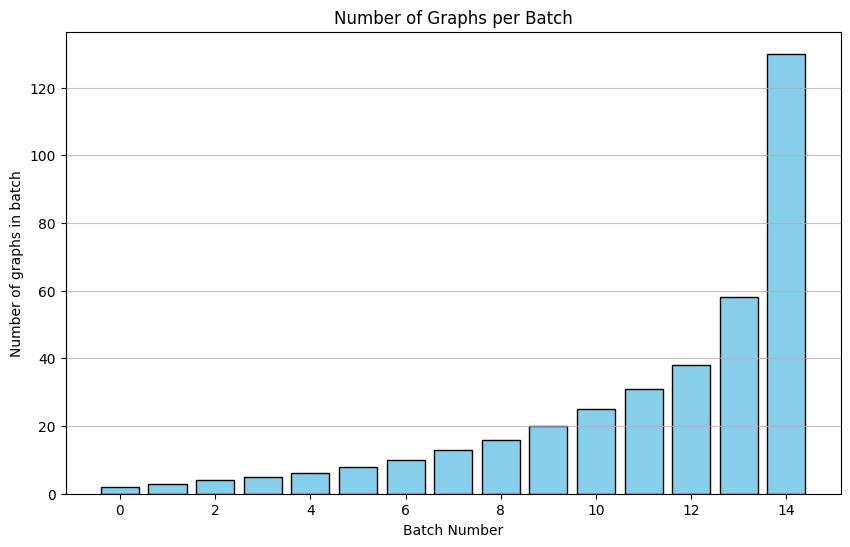

In [36]:
# ---------------------------
# Step 1: Create a dataset
# ---------------------------
df = camels_graph.copy()
df = df[['gauge_id', 'huc_02', 'num_nodes']]
df['gauge_id_concat'] = df['huc_02'] + '_' + df['gauge_id']
print(df.shape)

# ---------------------------
# Step 2: Define the maximum nodes per batch.
# ---------------------------
MAX_NODES_PER_BATCH = 1160

batches = create_batches(
    df = df, 
    MAX_NODES_PER_BATCH = MAX_NODES_PER_BATCH,
    id_column = 'gauge_id_concat',
    num_nodes_column = 'num_nodes'
    )

# Save as a JSON file.
with open(os.path.join(SAVE_PATH, 'nested_gauges', 'batches_AllHUCs_1160_nodes.json'), 'w') as f:
    json.dump(batches, f, indent=4)

(25, 4)

Batch assignments:
Batch 0: 2 graphs, Total nodes = 127.0
Batch 1: 2 graphs, Total nodes = 126.0
Batch 2: 3 graphs, Total nodes = 128.0
Batch 3: 2 graphs, Total nodes = 122.0
Batch 4: 3 graphs, Total nodes = 128.0
Batch 5: 6 graphs, Total nodes = 128.0
Batch 6: 7 graphs, Total nodes = 77.0

Total number of batches created: 7


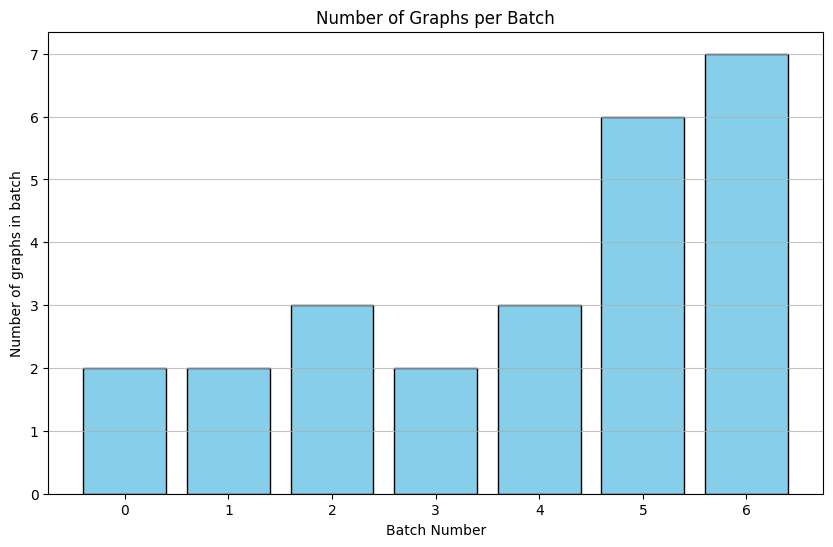

In [10]:
# ---------------------------
# Step 1: Create a dataset
# ---------------------------
df = camels_graph.copy()
df = df[['gauge_id', 'huc_02', 'num_nodes']]
df['gauge_id_concat'] = df['huc_02'] + '_' + df['gauge_id']
df = df[df['huc_02'] == '05']
print(df.shape)

# ---------------------------
# Step 2: Define the maximum nodes per batch.
# ---------------------------
MAX_NODES_PER_BATCH = 128

batches = create_batches(
    df = df, 
    MAX_NODES_PER_BATCH = MAX_NODES_PER_BATCH,
    id_column = 'gauge_id_concat',
    num_nodes_column = 'num_nodes'
    )

# Save as a JSON file.
with open(os.path.join(SAVE_PATH, 'nested_gauges', 'batches_HUC05_128_nodes.json'), 'w') as f:
    json.dump(batches, f, indent=4)